<a href="https://colab.research.google.com/github/TrunnMosby/GSoC-RedHenLabs-Aztec-Glyph-Detection/blob/main/ResNet101_augmnetedimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import  os
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import base64
from PIL import Image
import io
import math 
from math import sqrt

In [ ]:
base_models=tf.keras.applications.ResNet101()

179650560/179648224 [==============================] - 2s 0us/step


In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=base_models.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


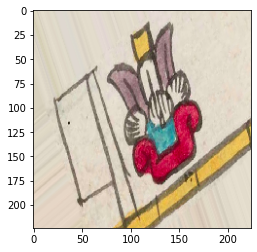

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
predictions = base_models.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

49152/35363 [=========================================] - 0s 0us/step
predicted handkerchief with probability 0.834
predicted pencil_box with probability 0.028
predicted doormat with probability 0.023
predicted pillow with probability 0.016
predicted bath_towel with probability 0.006


In [ ]:
base_models.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
feat_extractor = Model(inputs=base_models.input, outputs=base_models.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 42,658,176
Trainable params: 42,552,832
Non-trainable params: 105,344
__________________________________________________________________________________________________


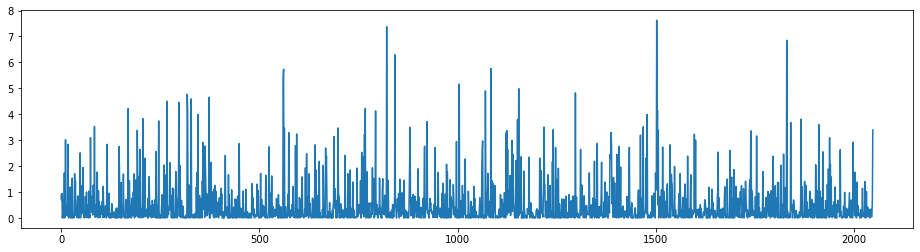

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [ ]:
images_path = '/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images'
image_extensions = ['.jpg', '.png', '.jpeg']   
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 6473 images to analyze


In [ ]:
import time
tic = time.clock()
features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


analyzing image 0 / 6473. Time: 0.0007 seconds.
analyzing image 500 / 6473. Time: 346.7081 seconds.
analyzing image 1000 / 6473. Time: 349.4722 seconds.
analyzing image 1500 / 6473. Time: 347.6785 seconds.
analyzing image 2000 / 6473. Time: 347.0785 seconds.
analyzing image 2500 / 6473. Time: 347.9790 seconds.
analyzing image 3000 / 6473. Time: 347.2705 seconds.
analyzing image 3500 / 6473. Time: 346.4202 seconds.
analyzing image 4000 / 6473. Time: 348.9913 seconds.
analyzing image 4500 / 6473. Time: 349.2297 seconds.
analyzing image 5000 / 6473. Time: 344.7018 seconds.
analyzing image 5500 / 6473. Time: 345.5132 seconds.
analyzing image 6000 / 6473. Time: 351.5152 seconds.
finished extracting features for 6473 images


In [ ]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


def get_closest_images2(query_image_idx, num_results=5):
    distances = [ distance.cosine(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return distances

[1029, 1028, 4467, 1027, 4469]
[0.3100937008857727, 0.326956570148468, 0.3212176561355591, 0.4133951663970947, 0.3204689025878906]
Names of the similar images:-
Tlacopan5vSIMPLEX.jpg_0_6465.png
Tlacopan5vSIMPLEX.jpg_0_3898.png
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_991.png
Tlacopan5vSIMPLEX.jpg_0_673.png
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_6743.png


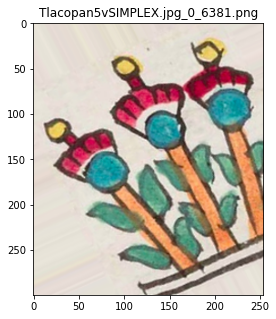

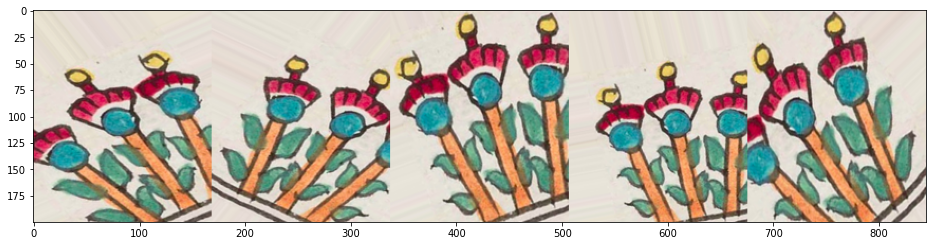

In [ ]:
query_image_idx = 1030
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print(idx_closest)
print(get_closest_images2(query_image_idx)[:5])
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

[0.41912025213241577, 0.4334448575973511, 0.41416966915130615, 0.5385164022445679, 0.449099600315094]
Names of the similar images:-
Cillan12rSIMPLEX.jpeg_0_577.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_3795.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_5056.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_5026.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_2148.png


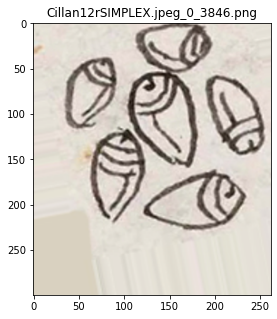

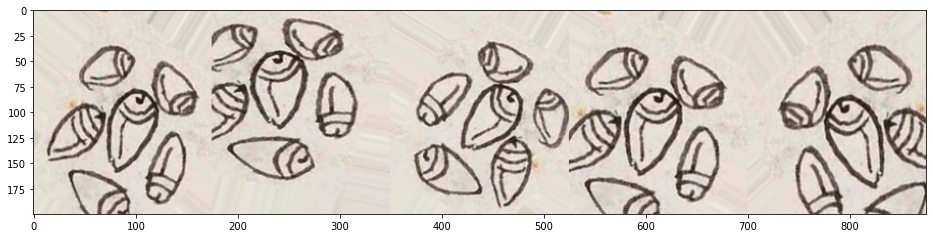

In [ ]:
query_image_idx = 1005
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print(get_closest_images2(query_image_idx)[:5])
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

[0.5676492750644684, 0.6167438626289368, 0.5903306901454926, 0.6442044973373413, 0.5743516385555267]
Names of the similar images:-
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_7586.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_6837.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_5180.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_8111.png
apantli07vwaterchannelFromTotolapan.jpg_0_7240.png


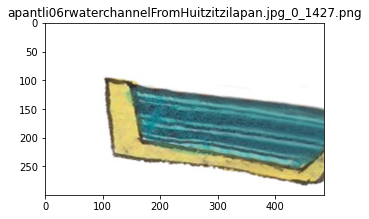

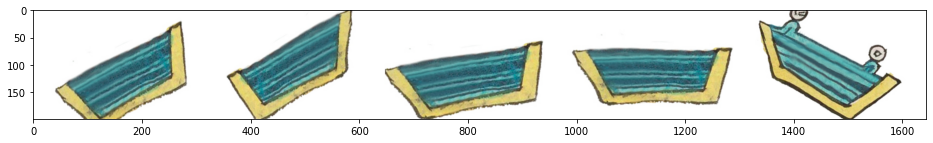

In [ ]:
query_image_idx = 1200
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)

print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])